In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler

import tensorflow as tf

In [2]:
# Set random seed for TensorFlow
tf.random.set_seed(123)

# Set random seed for Python
np.random.seed(123)

In [3]:
tf.keras.utils.set_random_seed(1)

tf.config.experimental.enable_op_determinism()

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:

data_all_county = pd.read_csv('/content/drive/My Drive/time_series/CA_data_lat_log_weekly.csv')


In [6]:
data_all_county['date'] = pd.to_datetime(data_all_county['date'])
data_all_county['month'] = data_all_county['date'].dt.month

Define helper functions

In [7]:
def ts_multi_data_prep(dataset, target, start, end, window, step_out):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - step_out
        #end = len(dataset)
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i, i+step_out) #revise the window definition
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [8]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    mse = metrics.mean_squared_error(y_true.flatten(), y_pred.flatten())
    mae = metrics.mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    #mape = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten())
    r2 = metrics.r2_score(y_true.flatten(), y_pred.flatten())
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    #print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}\n')

In [9]:
def single_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    #print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [10]:
def timeseries_evaluation_metrics_binary(y_true, y_pred):
    print('Evaluation metric results:-')
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision = precision_score(y_true.flatten(), y_pred.flatten(), average='macro')
    recall = recall_score(y_true.flatten(), y_pred.flatten(), average='macro')
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}\n')

In [11]:
hist_window = 30
step_out = 12
x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = [], [], [], [], [], []
unique_fips = data_all_county['fips'].unique()
unique_fips_count = data_all_county['fips'].nunique()
for fips in unique_fips:
    # Extract dataframe for the current FIPS value
    data_county = data_all_county[data_all_county['fips'] == fips]

    X_data = data_county[['lat','lon','PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score','month']]
    Y_data = data_county[['score']]
    #train_val_test split 70%-10%-20%
    n = len(X_data)

    x_train_county = X_data[0:int(n*0.7)]
    y_train_county = Y_data[0:int(n*0.7)]
    x_vali_county = X_data[int(n*0.7):int(n*0.8)]
    y_vali_county = Y_data[int(n*0.7):int(n*0.8)]
    x_test_county = X_data[int(n*0.8):]
    y_test_county = Y_data[int(n*0.8):]


    if fips == 6001:
        x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = x_train_county, y_train_county, x_vali_county, y_vali_county, x_test_county, y_test_county

    else:
        x_train_c = np.concatenate((x_train_c, x_train_county), axis=0)
        y_train_c = np.concatenate((y_train_c, y_train_county), axis=0)
        x_vali_c = np.concatenate((x_vali_c, x_vali_county), axis=0)
        y_vali_c = np.concatenate((y_vali_c, y_vali_county), axis=0)
        x_test_c = np.concatenate((x_test_c, x_test_county), axis=0)
        y_test_c = np.concatenate((y_test_c, y_test_county), axis=0)


In [12]:
x_train_c.shape

(44486, 22)

In [13]:
x_vali_c.shape

(6322, 22)

In [14]:
X_scaler_train = MinMaxScaler()
Y_scaler_train = MinMaxScaler()
X_scaler_test = MinMaxScaler()
Y_scaler_test = MinMaxScaler()
X_scaler_vali = MinMaxScaler()
Y_scaler_vali = MinMaxScaler()
x_train_data = X_scaler_train.fit_transform(x_train_c)
y_train_data = Y_scaler_train.fit_transform(y_train_c)
x_vali_data = X_scaler_vali.fit_transform(x_vali_c)
y_vali_data = Y_scaler_vali.fit_transform(y_vali_c)
x_test_data = X_scaler_test.fit_transform(x_test_c)
y_test_data = Y_scaler_test.fit_transform(y_test_c)

In [15]:
x_train_data.shape

(44486, 22)

In [16]:
def transform_county_data(x_data_array, y_data_array):
    # Lists to store x_train_c and y_train_c arrays
    x_c_list = []
    y_c_list = []
    # Divide the arrays into 'unique_fips_count' number of subarrays
    x_subarrays = np.array_split(x_data_array, unique_fips_count, axis=0)
    y_subarrays = np.array_split(y_data_array, unique_fips_count, axis=0)

    # Combine x_subarrays and y_subarrays into tuples
    data_tuples = [(x_subarray, y_subarray) for x_subarray, y_subarray in zip(x_subarrays, y_subarrays)]

    # Print or use the data tuples as needed
    for idx, data_tuple in enumerate(data_tuples):
        x_window_c, y_window_c = ts_multi_data_prep(data_tuple[0],data_tuple[1], 0, None, hist_window, step_out)
        # Append x_window_c and y_window_c arrays to lists
        x_c_list.append(x_window_c)
        y_c_list.append(y_window_c)

    # Stack arrays in lists to create x_train_c and y_train_c
    x_all_county = np.vstack(x_c_list)
    y_all_county = np.vstack(y_c_list)

    return x_all_county, y_all_county

In [17]:
x_train, y_train = transform_county_data(x_train_data, y_train_data)
x_vali, y_vali = transform_county_data(x_vali_data, y_vali_data)
x_test, y_test = transform_county_data(x_test_data, y_test_data)

In [18]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target\n')
print (y_train[0])

Multiple window of past history

[[5.29947117e-01 2.39715878e-01 2.92802021e-03 9.25820402e-01
  2.91703421e-01 3.93943140e-01 5.81672307e-01 5.74511770e-01
  3.60592630e-01 4.43743965e-01 3.41569163e-01 4.16622459e-01
  1.76152575e-01 2.16563083e-01 1.30602590e-01 2.49950070e-01
  2.20314920e-01 2.82671804e-01 1.43181818e-01 3.46506550e-01
  1.21580000e-01 0.00000000e+00]
 [5.29947117e-01 2.39715878e-01 2.85802090e-02 9.19918596e-01
  2.93541115e-01 4.06153001e-01 5.68814845e-01 5.62069488e-01
  3.85812222e-01 4.46299767e-01 3.92053216e-01 4.21354682e-01
  2.18351104e-01 2.93598508e-01 1.89077025e-01 3.03175554e-01
  2.74006195e-01 3.01805130e-01 2.41711230e-01 2.49606987e-01
  1.00720000e-01 0.00000000e+00]
 [5.29947117e-01 2.39715878e-01 1.04589224e-01 9.03841262e-01
  3.81064393e-01 4.46916632e-01 6.60853074e-01 6.54908788e-01
  3.91114563e-01 5.04884421e-01 2.81166479e-01 4.50917509e-01
  1.99579516e-01 3.13486638e-01 1.20683931e-01 4.17415618e-01
  2.65358802e-01 3.64192969e-01 1

In [19]:
batch_size = 128
buffer_size = 256

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [20]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
cnn_model.add(tf.keras.layers.MaxPool1D(pool_size=2))
cnn_model.add(tf.keras.layers.Dropout(0.1))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(30, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.1))
cnn_model.add(tf.keras.layers.Dense(units=step_out))
cnn_model.compile(optimizer='adam', loss='mae')

In [21]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            4288      
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 30)                26910     
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                        

In [22]:
model_path = '/content/drive/My Drive/time_series/cnn_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [23]:
history = cnn_model.fit(train_data,epochs=150,steps_per_epoch=50,validation_data=val_data,validation_steps=150,verbose=1,callbacks=callbacks)

Epoch 1/150
50/50 [==============================] - 4s 13ms/step - loss: 0.1838 - val_loss: 0.2581
Epoch 2/150
28/50 [===============>..............] - ETA: 0s - loss: 0.1364

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 1s 11ms/step - loss: 0.1318 - val_loss: 0.1051
Epoch 3/150
50/50 [==============================] - 1s 10ms/step - loss: 0.1110 - val_loss: 0.1074
Epoch 4/150
50/50 [==============================] - 1s 10ms/step - loss: 0.1060 - val_loss: 0.1688
Epoch 5/150
50/50 [==============================] - 1s 10ms/step - loss: 0.0989 - val_loss: 0.1075
Epoch 6/150
50/50 [==============================] - 1s 11ms/step - loss: 0.0921 - val_loss: 0.1303
Epoch 7/150
50/50 [==============================] - 1s 17ms/step - loss: 0.0927 - val_loss: 0.0956
Epoch 8/150
50/50 [==============================] - 1s 15ms/step - loss: 0.0804 - val_loss: 0.1659
Epoch 9/150
50/50 [==============================] - 1s 21ms/step - loss: 0.0890 - val_loss: 0.0810
Epoch 10/150
50/50 [==============================] - 1s 25ms/step - loss: 0.0872 - val_loss: 0.0899
Epoch 11/150
50/50 [==============================] - 1s 18ms/step - loss: 0.0846 - val_loss: 0.1287
Epoch 12/1

In [24]:
#plt.figure(figsize=(16,9))
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train loss', 'validation loss'])
#plt.show()

In [25]:
y_test_pred = cnn_model.predict(x_test)
y_test_pred_Inverse = Y_scaler_test.inverse_transform(y_test_pred)

323/323 [==============================] - 1s 3ms/step


In [26]:
y_test_pred_Inverse_ordinal = np.round(y_test_pred_Inverse).astype(int)

In [27]:
y_test_reshaped = np.squeeze(y_test, axis=-1)

In [28]:
y_test_Inverse = Y_scaler_test.inverse_transform(y_test_reshaped)
y_test_Inverse_ordinal = np.round(y_test_Inverse).astype(int)

In [29]:
threshold = 2.5
y_test_Inverse_binary = np.where(y_test_Inverse >= threshold, 1, 0)
y_test_pred_Inverse_binary = np.where(y_test_pred_Inverse >= threshold, 1, 0)

In [30]:
timeseries_evaluation_metrics_func(y_test_Inverse,y_test_pred_Inverse)

Evaluation metric results:-
MSE is : 0.3555114344847814
MAE is : 0.36733402024920003
RMSE is : 0.5962477962095805
R2 is : 0.6705141301678041



In [31]:
timeseries_evaluation_metrics_binary(y_test_Inverse_binary,y_test_pred_Inverse_binary)

Evaluation metric results:-
Accuracy: 0.9526265659305179
Precision: 0.8912311811002422
Recall: 0.8471126039986874
F1-score: 0.8674234844278756



In [32]:
# Compute classification report
classification_metrics = classification_report(y_test_Inverse_binary.flatten(),y_test_pred_Inverse_binary.flatten())
#classification_metrics = classification_report(y_test_Inverse_ordinal.flatten(),y_test_pred_Inverse_ordinal.flatten())
# Print classification report
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    110778
           1       0.82      0.71      0.76     13110

    accuracy                           0.95    123888
   macro avg       0.89      0.85      0.87    123888
weighted avg       0.95      0.95      0.95    123888



Confusion Matrix:
[[108668   2110]
 [  3759   9351]]


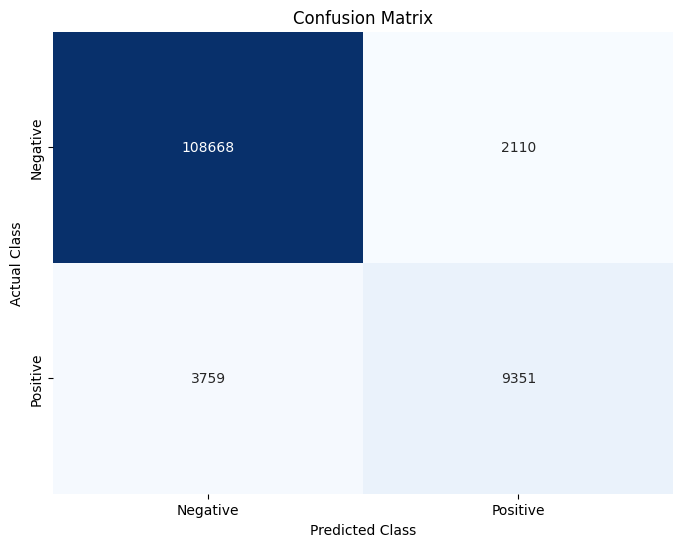

In [33]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_Inverse_binary.flatten(), y_test_pred_Inverse_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

(0.0, 5.0)

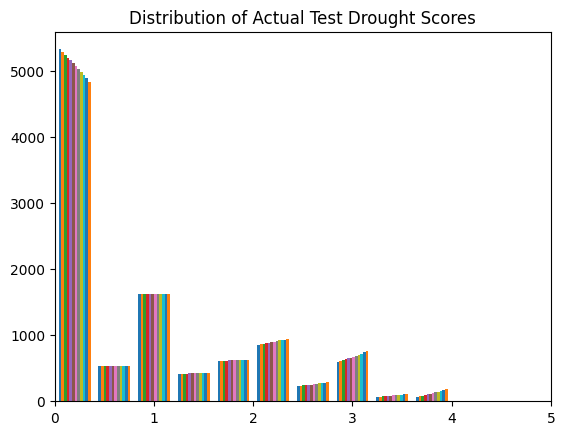

In [34]:
plt.hist(y_test_Inverse)
plt.title('Distribution of Actual Test Drought Scores')
plt.xlim(0, 5)

(0.0, 5.0)

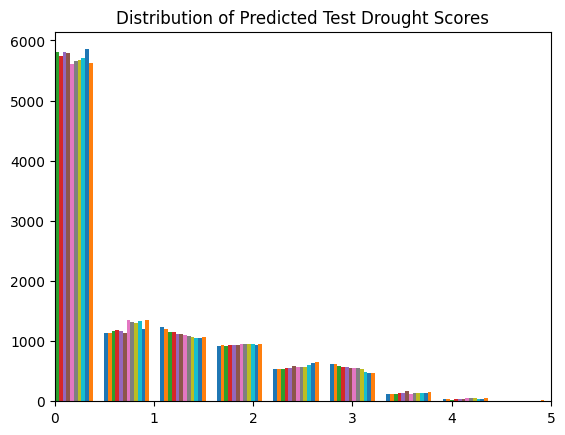

In [35]:
plt.hist(y_test_pred_Inverse)
plt.title('Distribution of Predicted Test Drought Scores')
plt.xlim(0, 5)